# Datathon

## 분석 목표
묶음 판매 행사를 열기 위해 어떤 품목을 많이 구매를 하였는지 파악하고, 구매한 품목 별 관계를 통해 세트로 판매할 품목을 정하고자 한다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

%matplotlib inline

sns.set_style("darkgrid")
sns.set_palette("muted")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# 데이터 불러오기
orders = pd.read_csv('data/orders.csv' )
order_products_train = pd.read_csv('data/order_products__train.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')

In [3]:
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
print(order_products_prior.shape)
order_products_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


<AxesSubplot:>

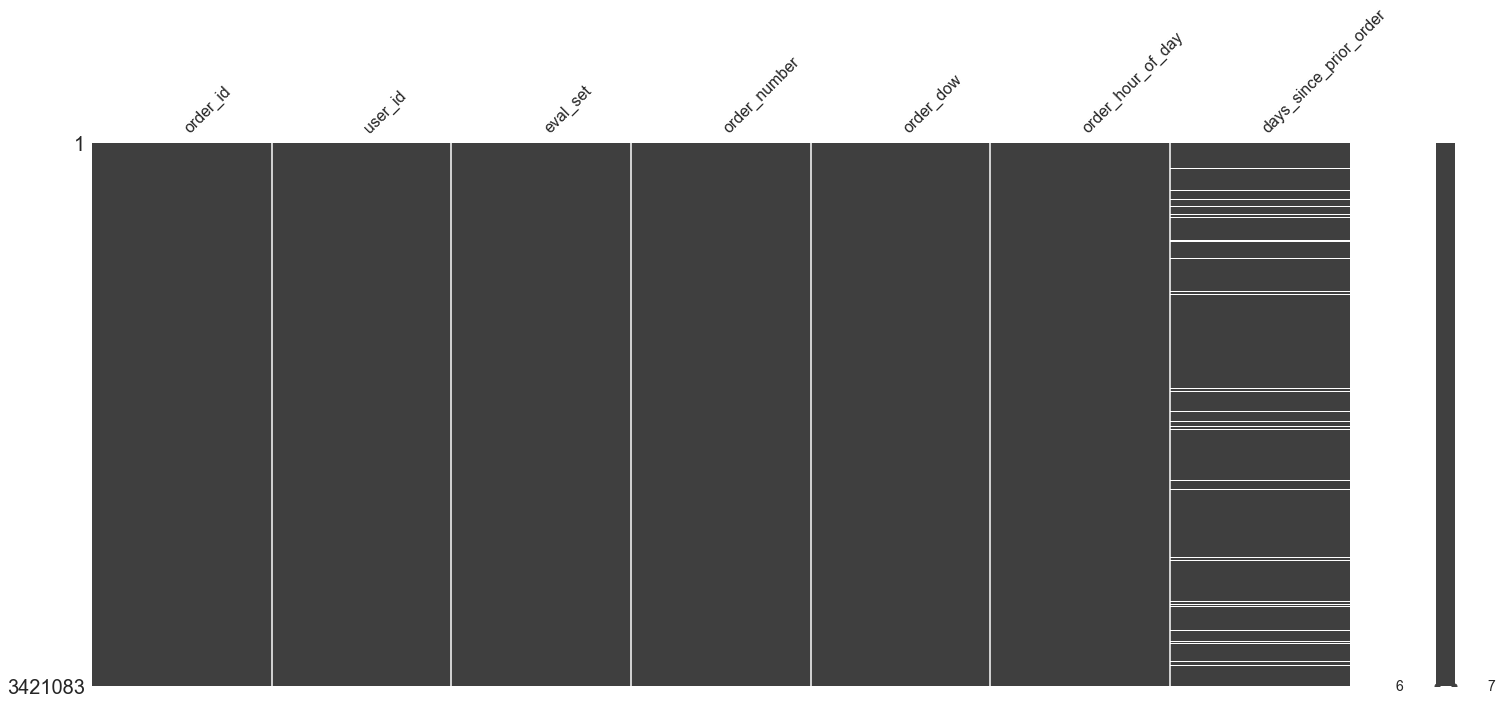

In [8]:
msno.matrix(df=orders)

<AxesSubplot:>

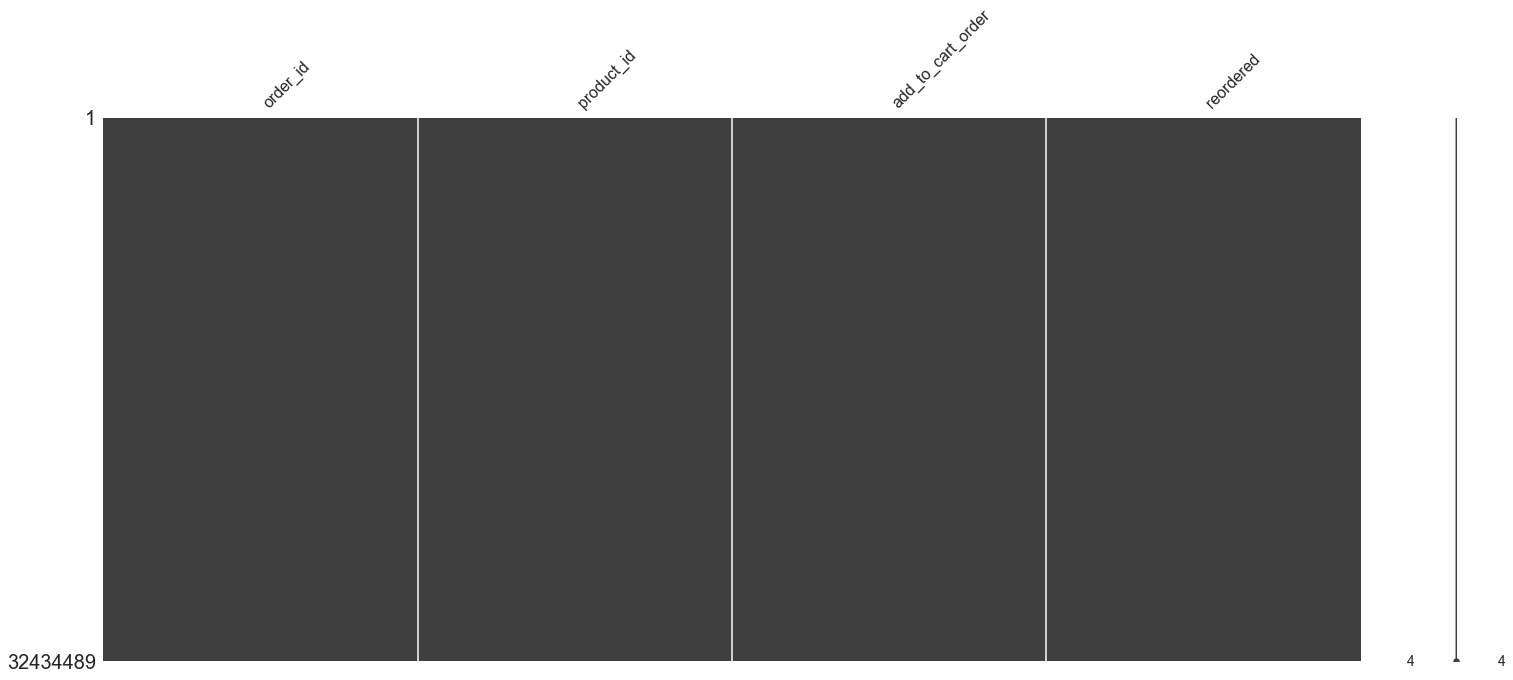

In [9]:
msno.matrix(order_products_prior)

<AxesSubplot:>

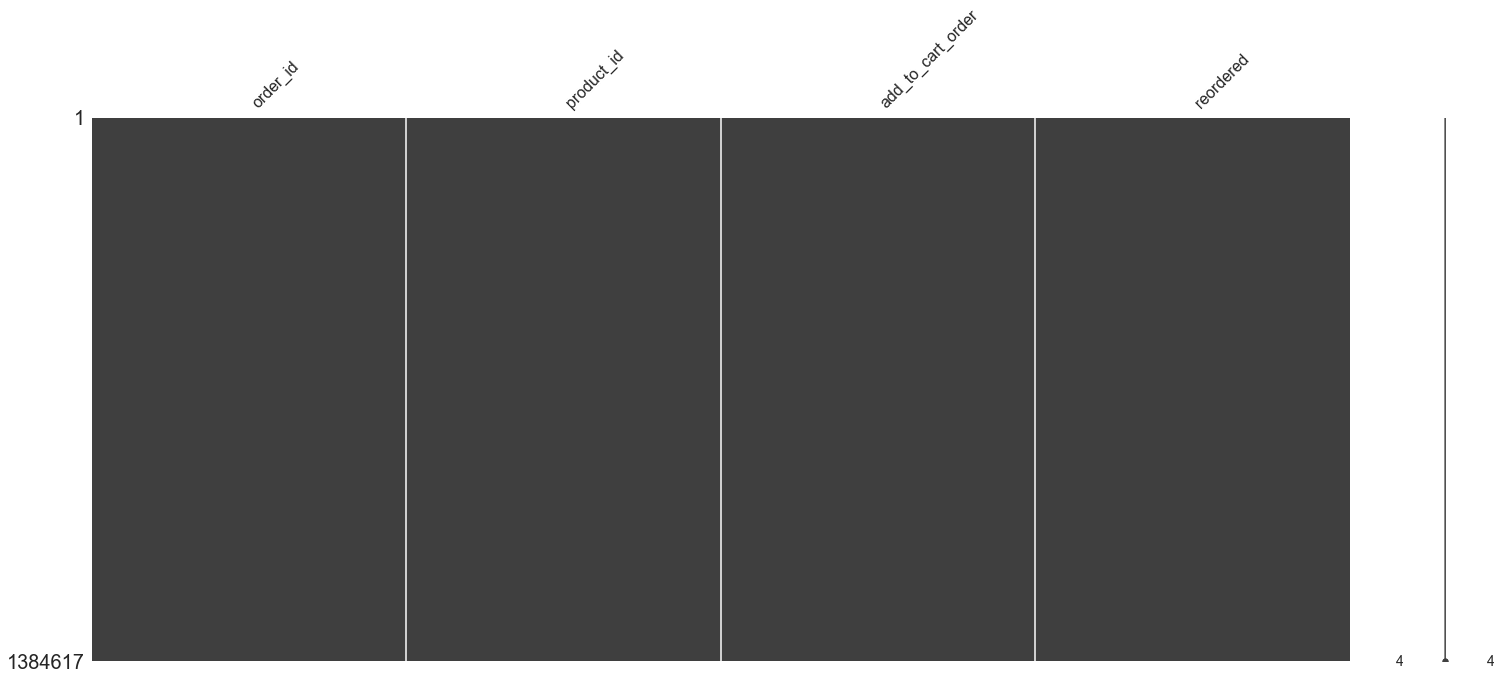

In [10]:
msno.matrix(order_products_train)

<AxesSubplot:>

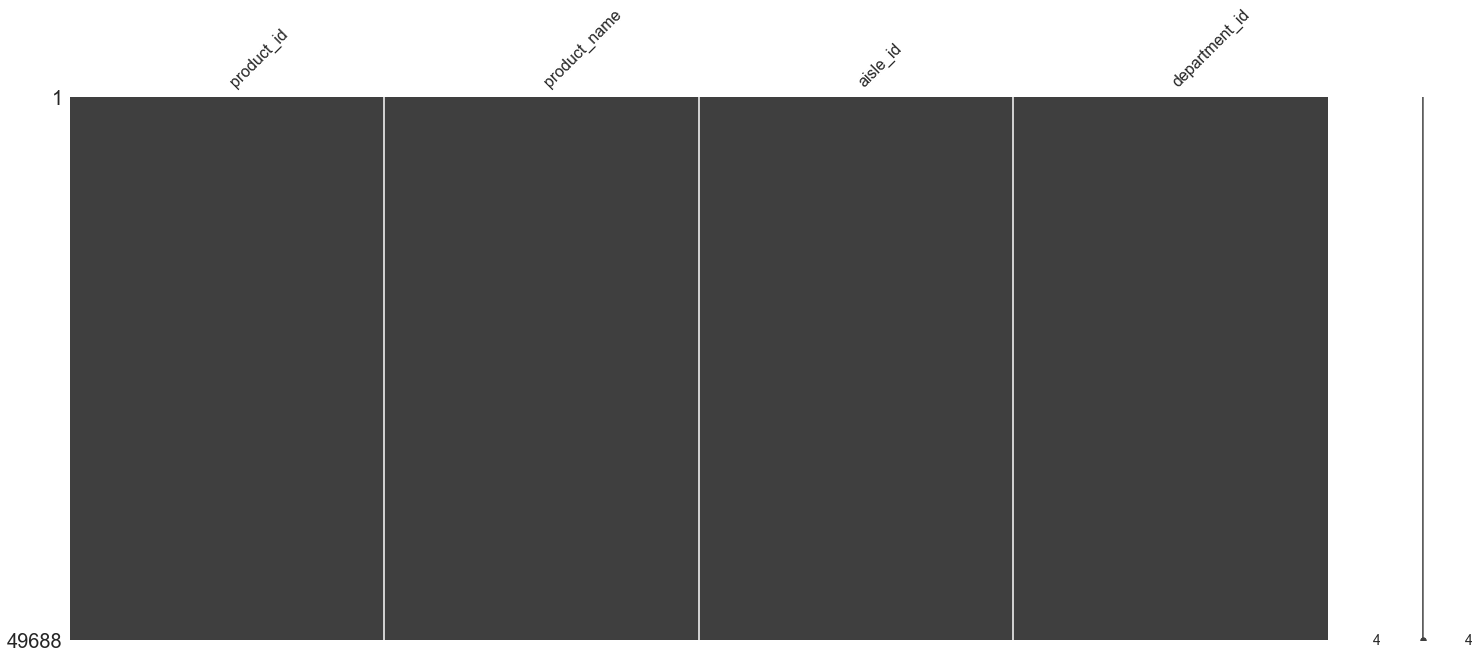

In [11]:
msno.matrix(products)

<AxesSubplot:>

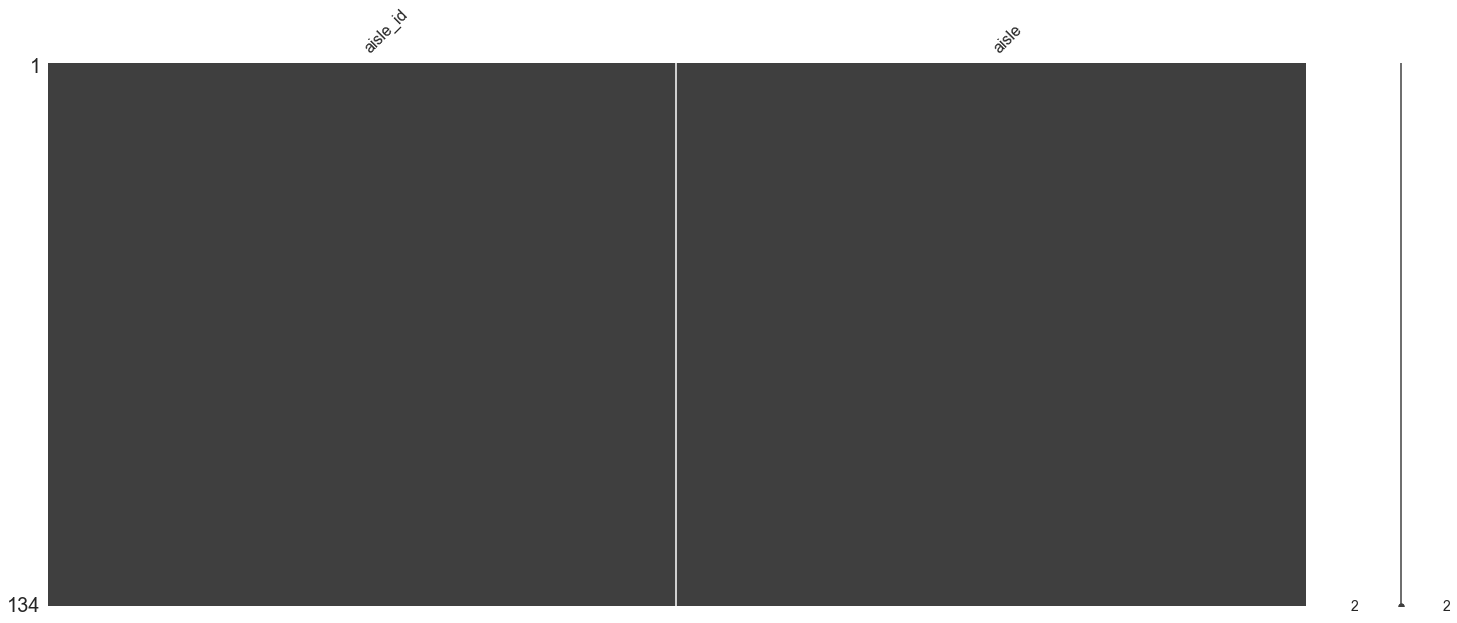

In [12]:
msno.matrix(aisles)

<AxesSubplot:>

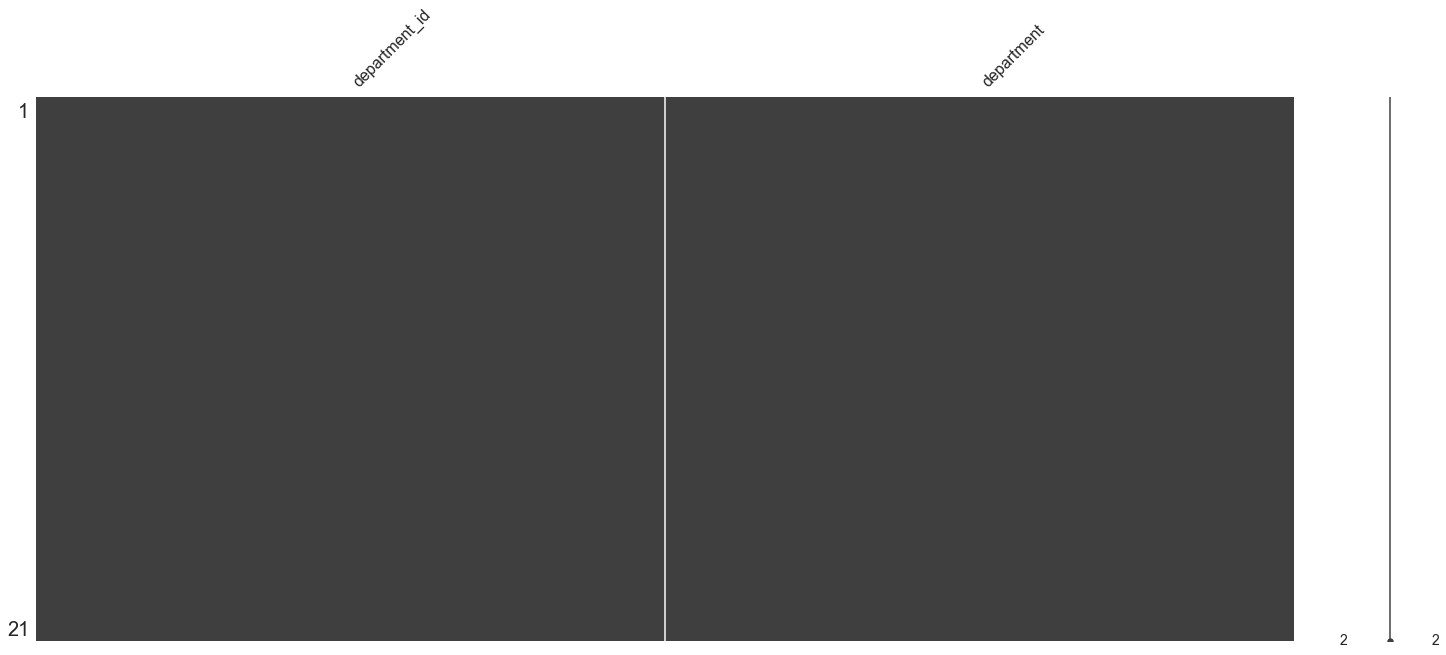

In [13]:
msno.matrix(departments)

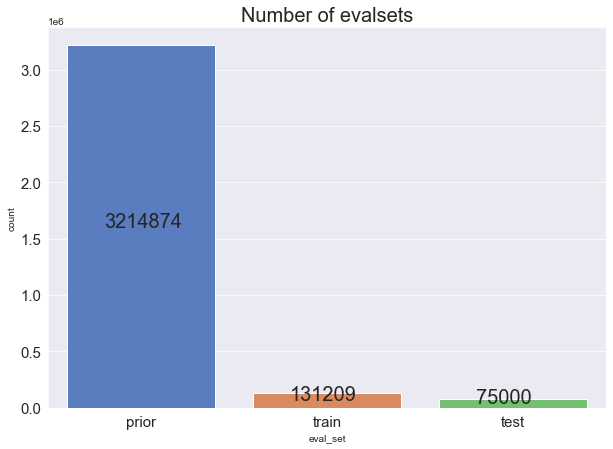

In [19]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(x='eval_set', data=orders);
for p in ax.patches:
    counts = p.get_height()
    x = p.get_x() + p.get_width() / 2 - 0.2
    y = p.get_y() + p.get_height() / 2
    ax.annotate(counts, (x, y), size = 20)
    ax.tick_params(labelsize=15)
plt.title('Number of evalsets', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
plt.show()

In [22]:
orders = orders.loc[orders.eval_set=="prior"] # prior data만 사용
print(orders.shape)

(3214874, 7)


In [23]:
tmp_df = pd.merge(order_products_prior, products, on="product_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 7)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [24]:
tmp_df = pd.merge(tmp_df, aisles, on="aisle_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 8)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients


In [25]:
tmp_df = pd.merge(tmp_df, departments, on="department_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 9)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


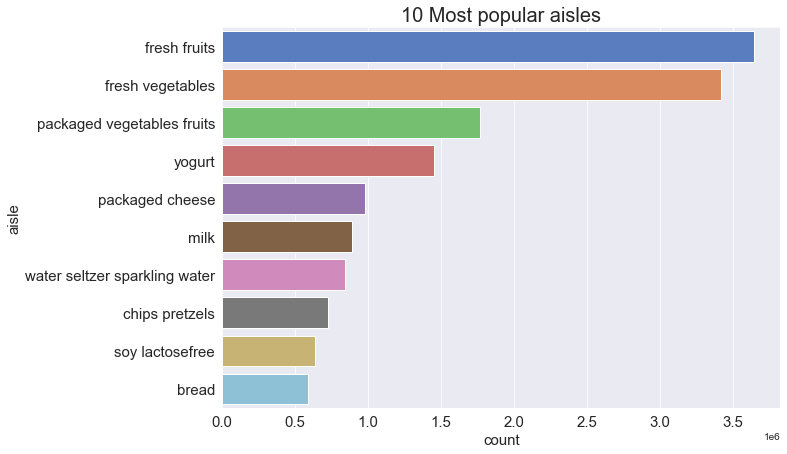

In [32]:
# 어느 진열대에서 많이 팔렸는가?
plt.figure(figsize=(10, 7))
ax = sns.countplot(y="aisle", data=tmp_df, order = tmp_df.aisle.value_counts().iloc[:10].index) # 상위 10개
plt.title('10 Most popular aisles', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
plt.ylabel("aisle", fontdict={'fontsize': 15})
plt.xlabel("count", fontdict={'fontsize': 15})

plt.show()

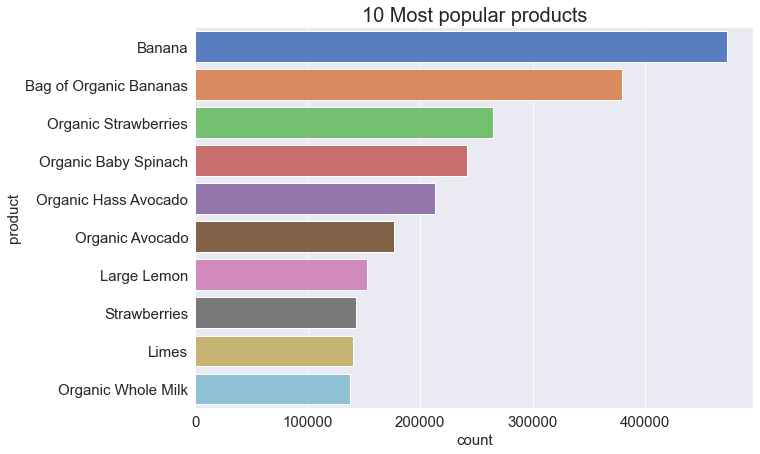

In [34]:
# 주문 품목 순위
plt.figure(figsize=(10, 7))
ax = sns.countplot(y="product_name", data=tmp_df, order = tmp_df.product_name.value_counts().iloc[:10].index); # 상위 10개
plt.title('10 Most popular products', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
plt.ylabel("product", fontdict={'fontsize': 15})
plt.xlabel("count", fontdict={'fontsize': 15})

plt.show()

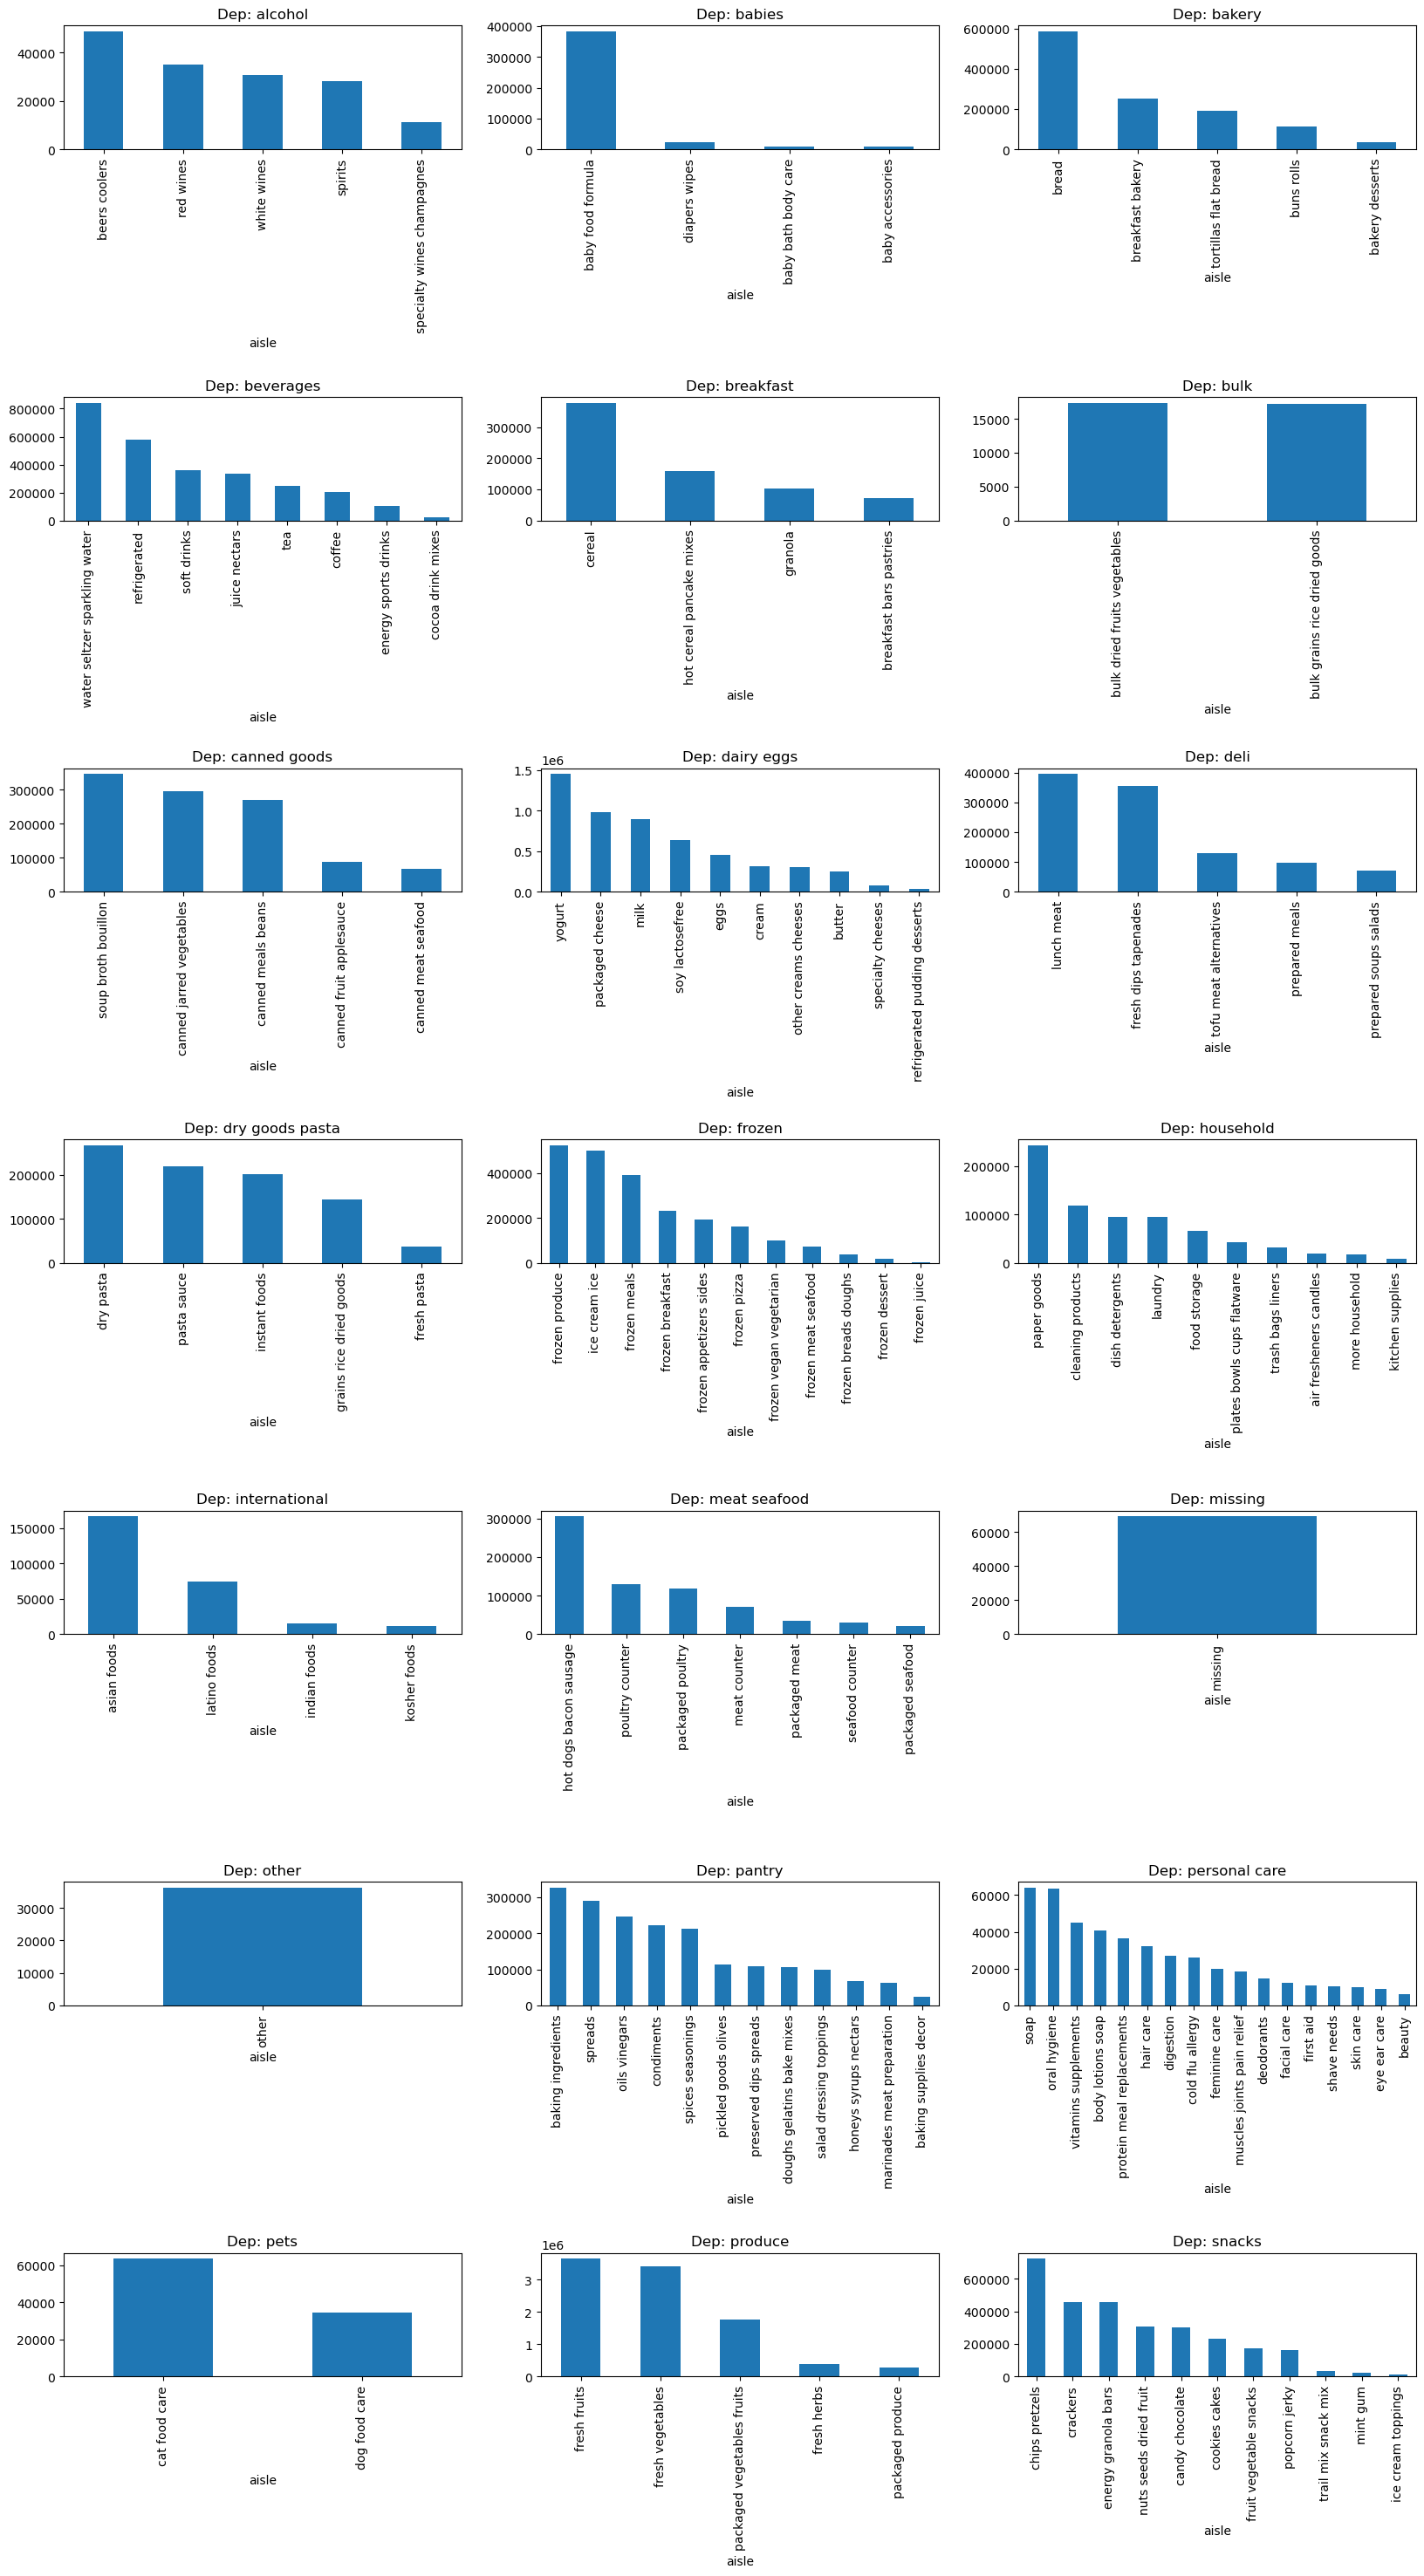

In [15]:
# 품목별 판매량 bar plot
f, axarr = plt.subplots(7, 3, figsize=(20, 35))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//3, i%3].set_title('Dep: {}'.format(e))
    tmp_df[tmp_df.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//3, i%3])
f.subplots_adjust(hspace=2)

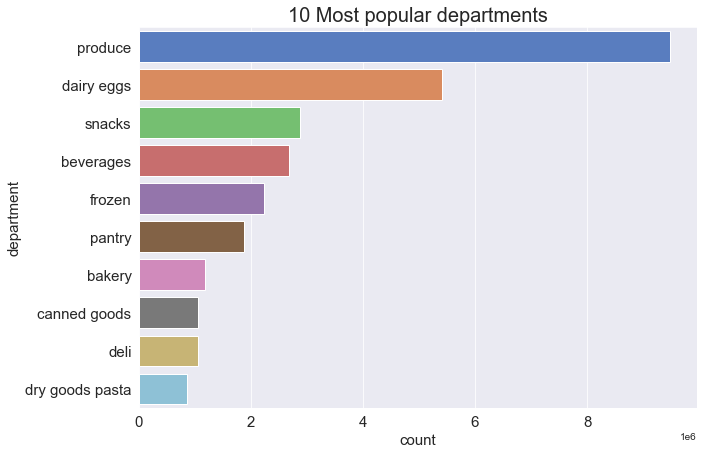

In [35]:
# 많이 팔린 department
plt.figure(figsize=(10, 7))
ax = sns.countplot(y="department", data=tmp_df, order = tmp_df.department.value_counts().iloc[:10].index); # 상위 10개
plt.title('10 Most popular departments', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
plt.ylabel("department", fontdict={'fontsize': 15})
plt.xlabel("count", fontdict={'fontsize': 15})

plt.show()

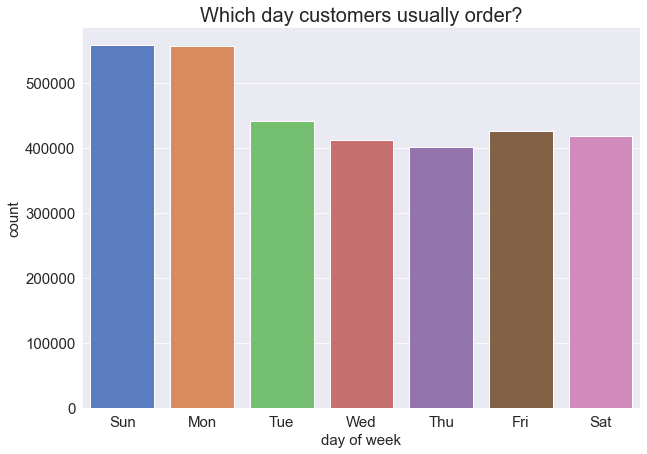

In [37]:
# 주문 요일
plt.figure(figsize=(10, 7))
ax = sns.countplot(x="order_dow", data=orders)
plt.title('Which day customers usually order?', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.ylabel("count", fontdict={'fontsize': 15})
plt.xlabel("day of week", fontdict={'fontsize': 15})

plt.show()

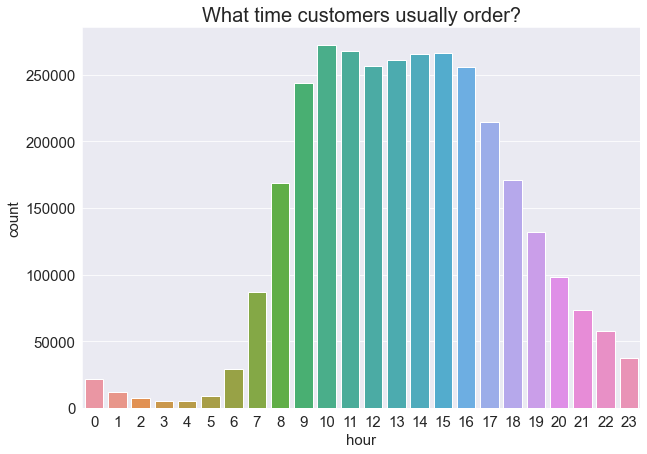

In [38]:
# 주문 시간
plt.figure(figsize=(10, 7))
ax = sns.countplot(x="order_hour_of_day", data=orders)
plt.title('What time customers usually order?', fontdict={'fontsize': 20})
ax.tick_params(labelsize=15)
plt.ylabel("count", fontdict={'fontsize': 15})
plt.xlabel("hour", fontdict={'fontsize': 15})

plt.show()

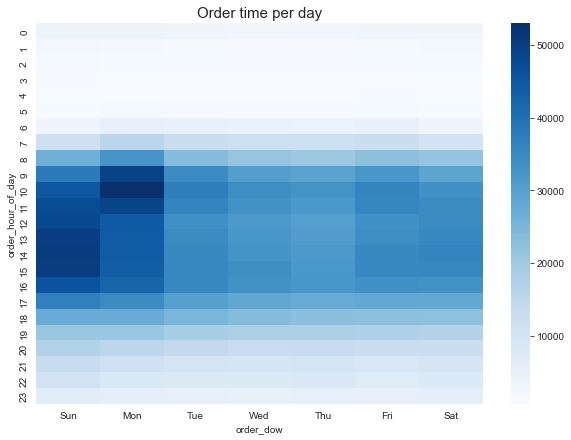

In [41]:
tmp = pd.crosstab(orders["order_hour_of_day"], orders["order_dow"])
plt.figure(figsize=(10, 7))
ax = sns.heatmap(tmp, cmap="Blues")
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.title('Order time per day', fontdict={'fontsize': 15})
plt.show()

아침~오후에 주문이 주로 많고, 일요일, 월요일에 주문량이 더 많다. <br>
특히 월요일 오전, 일요일 오후에 주문이 많다.

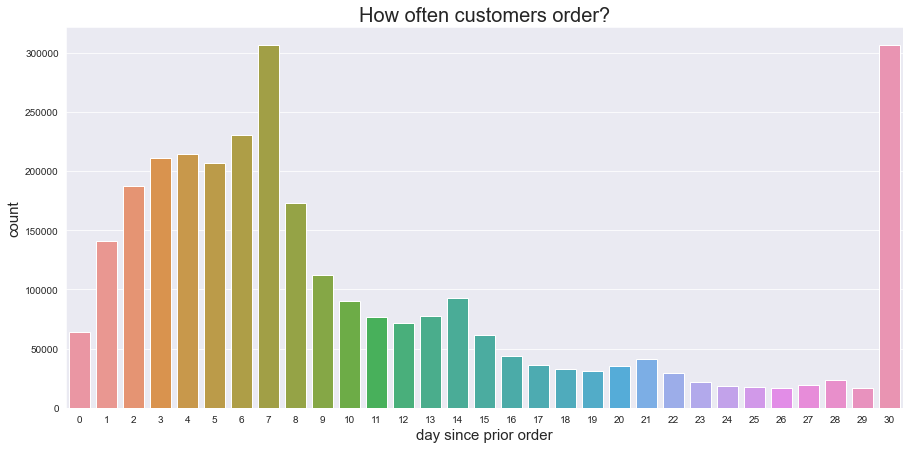

In [45]:
# 재구매 빈도
plt.figure(figsize=(15, 7))
ax = sns.countplot(x="days_since_prior_order", data=orders)
plt.title('How often customers order?', fontdict={'fontsize': 20})
ax.set_xticklabels(range(0, 31))
plt.ylabel("count", fontdict={'fontsize': 15})
plt.xlabel("day since prior order", fontdict={'fontsize': 15})

plt.show()

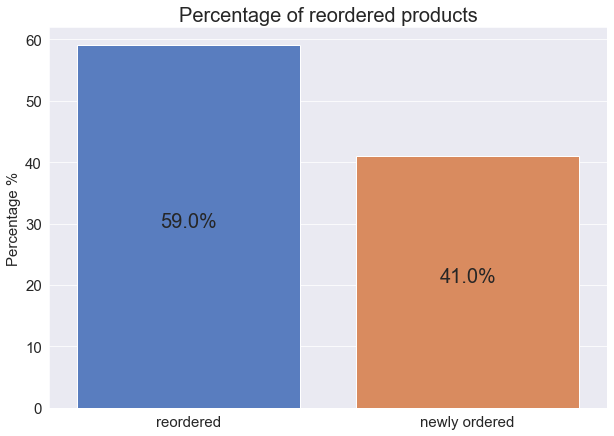

In [78]:
# 재구매율
tmp = tmp_df.reordered.value_counts(normalize=True)
tmp = tmp.rename({0: 'newly ordered', 1: 'reordered'})
tmp = tmp.mul(100).round(decimals=1)

plt.figure(figsize=(10, 7))
ax = sns.barplot(x=tmp.index, y=tmp.values)
for p in ax.patches:
    percentage = f'{p.get_height()}%'
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 20)
    
plt.title('Percentage of reordered products', fontdict={'fontsize': 20})
plt.ylabel('Percentage %', fontdict={'fontsize': 15})
ax.tick_params(labelsize=15)

plt.show()

In [46]:
tmp_df = pd.merge(tmp_df, orders, on="order_id", how="left")

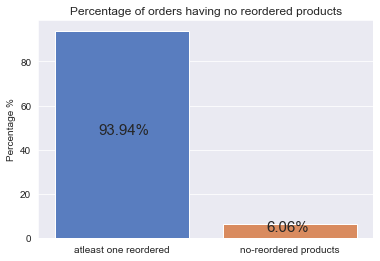

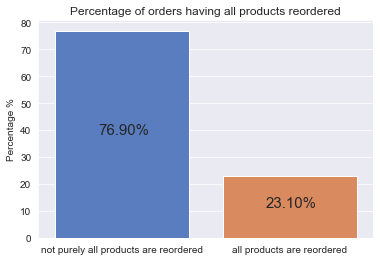

In [68]:
grouped_df = tmp_df.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
grouped_df['no_reordered'] = grouped_df['reordered_ratio'] == 0
grouped_df['all_reordered'] = grouped_df['reordered_ratio'] == 1.0

# 재주문인 것 찾아서 더하기
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# 재주문 품목이 있는 주문 vs 없는 주문
grouped_df = grouped_df[grouped_df.order_number != 1]
grouped_df['no_reordered'] = grouped_df['reordered_ratio'] == 0
no_reordered_count = grouped_df['no_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values)
ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])
for p in ax.patches:
    percentage = f'{p.get_height():.2f}%'
    x = p.get_x() + p.get_width() / 2 - 0.14
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 15)
plt.title('Percentage of orders having no reordered products')
plt.ylabel('Percentage %')
plt.show()

# 모든 품목이 재주문인 주문의 비율
grouped_df['all_reordered'] = grouped_df['reordered_ratio'] == 1.0
all_reordered_count = grouped_df['all_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values)
ax.set_xticklabels(['not purely all products are reordered', 'all products are reordered'])
for p in ax.patches:
    percentage = f'{p.get_height():.2f}%'
    x = p.get_x() + p.get_width() / 2 - 0.14
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 15)
plt.title('Percentage of orders having all products reordered')
plt.ylabel('Percentage %')
plt.show()

grouped_df.head()
del grouped_df

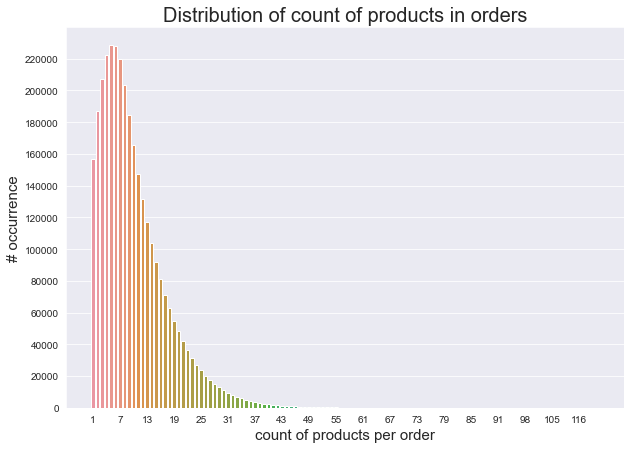

In [47]:
count_of_products = tmp_df.groupby(['order_id'], as_index=False)['product_id'].count()
plt.figure(figsize=(10, 7))
sns.countplot(x='product_id', data=count_of_products)
plt.title('Distribution of count of products in orders', fontdict={'fontsize': 20})
plt.xlabel('count of products per order', fontdict={'fontsize': 15})
plt.ylabel('# occurrence', fontdict={'fontsize': 15})
plt.locator_params(nbins=20)
plt.show()

del count_of_products

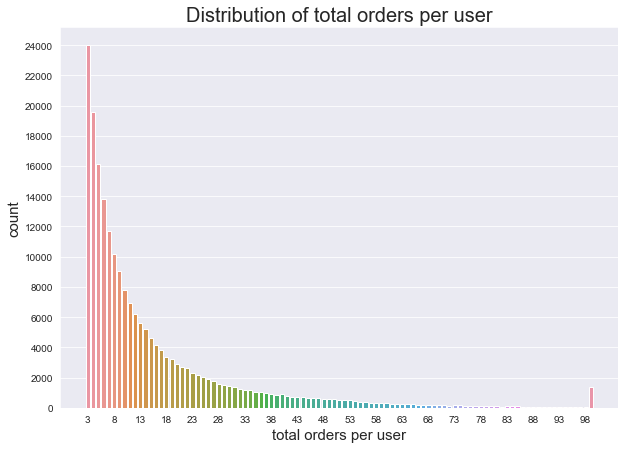

In [48]:
# 고객별 총 주문 수
total_orders = orders.groupby(['user_id'], as_index=False)['order_id'].count()
plt.figure(figsize=(10, 7))
sns.countplot(x='order_id', data=total_orders)
plt.title('Distribution of total orders per user', fontdict={'fontsize': 20})
plt.xlabel('total orders per user', fontdict={'fontsize': 15})
plt.ylabel('count', fontdict={'fontsize': 15})
plt.locator_params(nbins=20)
plt.show()

del total_orders

# 고객 클러스터링
- 고객이 구매한 상품의 진열대를 기준으로 클러스터링을 진행한다.
- PCA로 진열대 차원을 축소한 후 두 feature를 선택하여 클러스터링 진행한다.
- 클러스터 별로 어떠한 제품군을 많이 구매하는지 파악해본다.

In [50]:
cluster_df = tmp_df.drop('department', axis=1)

In [51]:
# 어떤 진열대의 상품을 구매했는지
user_aisle = pd.crosstab(cluster_df.user_id, cluster_df.aisle)
print(user_aisle.shape)
user_aisle.head()

(206209, 134)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [78]:
pca = PCA(n_components=6) # 진열대들을 6개의 feature로 축소
pca.fit(user_aisle)
pca_samples = pca.transform(user_aisle)

In [79]:
ps_df = pd.DataFrame(pca_samples)
ps_df.head()

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466369,-0.145708,0.269259,-1.433755
1,6.463208,36.751116,8.382553,15.097536,-6.920986,-0.978227
2,-7.990302,2.404383,-11.030064,0.672221,-0.442213,-2.823645
3,-27.991129,-0.755823,-1.921732,2.091888,-0.288230,0.926186
4,-19.896394,-2.637225,0.533229,3.679226,0.612871,-1.624095


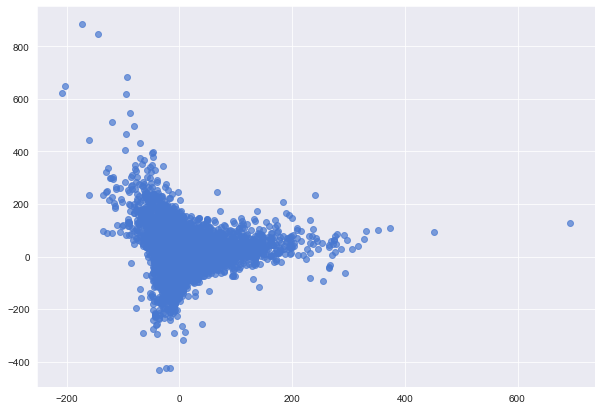

In [82]:
to_cluster = pd.DataFrame(ps_df[[4,1]])

plt.figure(figsize=(10, 7))
plt.scatter(to_cluster[4], to_cluster[1], alpha=0.7)
plt.show()

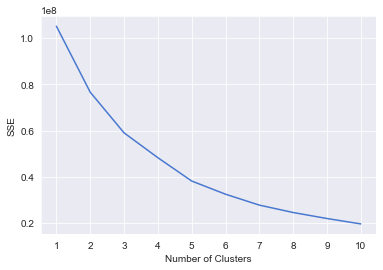

In [83]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(to_cluster)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

elbow method를 사용했을 때 `k=5`가 최적의 k라고 하지만, `k=5`일 때 두 클러스터의 중심점이 거의 붙어있고, 두 클러스터 내 고객의 구매 상품군도 비슷하기 때문에 `k=4`로 지정하였다.

In [84]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(to_cluster)
centers = kmeans.cluster_centers_
y_clusters = kmeans.predict(to_cluster)

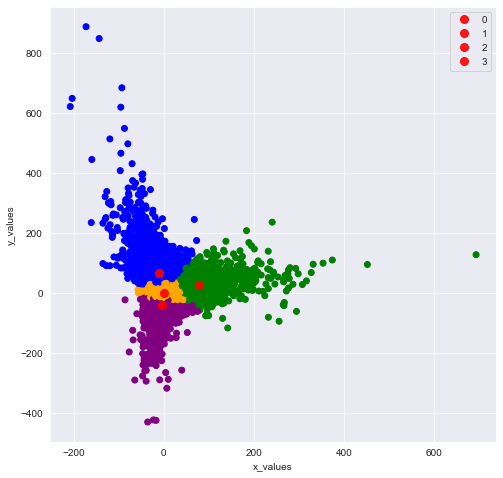

In [85]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green','yellow']
colored = [colors[k] for k in y_clusters]
plt.scatter(to_cluster[4], to_cluster[1], color = colored)
# plt.scatter(ps_df[0], ps_df[1], color=colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [86]:
cluster_product = user_aisle.copy()
cluster_product["cluster"] = y_clusters
user_set = pd.DataFrame(cluster_product['cluster']).reset_index()
user_set.head()

,user_id,cluster
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


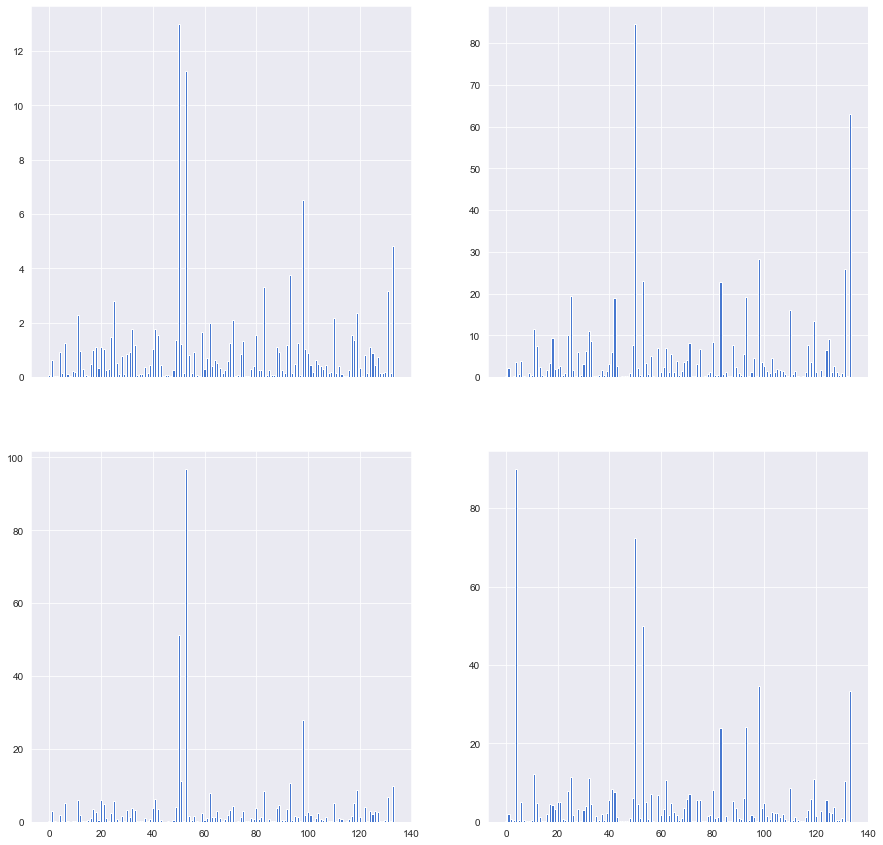

In [87]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(cluster_product[cluster_product['cluster']==0])

c0 = cluster_product[cluster_product['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c0)
c1 = cluster_product[cluster_product['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c1)
c2 = cluster_product[cluster_product['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c2)
c3 = cluster_product[cluster_product['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c3)

plt.show()

In [88]:
c0.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     12.996631
fresh vegetables                 11.260211
packaged vegetables fruits        6.531731
yogurt                            4.840481
packaged cheese                   3.754783
milk                              3.303046
water seltzer sparkling water     3.169569
chips pretzels                    2.782907
soy lactosefree                   2.349999
bread                             2.279087
refrigerated                      2.169248
ice cream ice                     2.082809
frozen produce                    2.001511
eggs                              1.777995
crackers                          1.766247
dtype: float64

In [89]:
c1.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     84.540978
yogurt                           63.034570
packaged vegetables fruits       28.155818
water seltzer sparkling water    25.798482
fresh vegetables                 22.905228
milk                             22.755312
chips pretzels                   19.477234
packaged cheese                  19.053288
energy granola bars              19.046712
refrigerated                     16.019393
soy lactosefree                  13.441315
bread                            11.524283
crackers                         11.005565
cereal                            9.979258
candy chocolate                   9.359359
dtype: float64

In [41]:
c2.sort_values(ascending=False)[0:15]

aisle
fresh vegetables                 96.875269
fresh fruits                     51.391756
packaged vegetables fruits       27.902778
fresh herbs                      11.309857
packaged cheese                  10.643459
yogurt                            9.923566
soy lactosefree                   8.795699
milk                              8.355556
frozen produce                    7.808244
water seltzer sparkling water     6.770072
eggs                              6.175448
canned jarred vegetables          6.095968
bread                             6.019803
chips pretzels                    5.795072
refrigerated                      5.278674
dtype: float64

In [90]:
c3.sort_values(ascending=False)[0:15]

aisle
baby food formula                90.031453
fresh fruits                     72.334056
fresh vegetables                 50.059111
packaged vegetables fruits       34.557484
yogurt                           33.242950
packaged cheese                  24.305315
milk                             23.996746
bread                            12.200651
chips pretzels                   11.457701
crackers                         11.247831
soy lactosefree                  11.003254
frozen produce                   10.577007
water seltzer sparkling water    10.527657
refrigerated                      8.530369
eggs                              8.318330
dtype: float64

c3 클러스터는 baby food formula로 확실하게 클러스터 구분이 된다. 아기가 있는 부모들이라고 볼 수 있을 것 같다.<br>

In [91]:
c0_prod = c0.sort_values(ascending=False)[0:20].index
c1_prod = c1.sort_values(ascending=False)[0:20].index
c2_prod = c2.sort_values(ascending=False)[0:20].index
c3_prod = c3.sort_values(ascending=False)[0:20].index

In [44]:
set(c0_prod) - set(c1_prod) - set(c2_prod) - set(c3_prod)

{'frozen meals', 'soft drinks'}

In [45]:
set(c1_prod) - set(c0_prod) - set(c2_prod) - set(c3_prod)

{'candy chocolate', 'cream', 'fresh dips tapenades', 'tea'}

In [46]:
set(c2_prod) - set(c0_prod) - set(c1_prod) - set(c3_prod)

{'baking ingredients',
 'canned jarred vegetables',
 'canned meals beans',
 'fresh herbs',
 'oils vinegars',
 'soup broth bouillon'}

In [47]:
set(c3_prod) - set(c0_prod) - set(c1_prod) - set(c2_prod)

{'baby food formula', 'frozen breakfast'}

In [48]:
n_order_df = order_products_prior.groupby("product_id", as_index=False).count()

In [49]:
less_ordered = n_order_df.loc[n_order_df.order_id < 100, 'product_id'].tolist()

In [50]:
products.loc[products.product_id.isin(less_ordered)]

,product_id,product_name,aisle_id,department_id
1,2,All-Seasons Salt,104,13
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
12,13,Saline Nasal Mist,11,11
...,...,...,...,...
49680,49681,Spaghetti with Meatballs and Sauce Meal,38,1
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


### 유저별 그룹 나누기

In [51]:
user_set.head()

,user_id,cluster
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [55]:
tmp_df = pd.merge(tmp_df, user_set, on='user_id', how='left')

In [56]:
tmp_df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21.0,0
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21.0,0
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21.0,0
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21.0,0


In [67]:
group0 = tmp_df[tmp_df['cluster']==0]
group1 = tmp_df[tmp_df['cluster']==1]
group2 = tmp_df[tmp_df['cluster']==2]
group3 = tmp_df[tmp_df['cluster']==3]

In [78]:
#Clustring 함수 정의
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

def Clustering(group):
    tmp = group.sample(n=1000)[['user_id','product_name']]
    basket = pd.crosstab(tmp['user_id'], tmp['product_name']).astype('bool').astype('int')
    
    basket = basket.reset_index(drop=True)
    
    frequent_itemsets_fp = fpgrowth(basket, min_support = 0.00002, use_colnames=True).sort_values('support', ascending=False)
    frequent_itemsets_fp['length'] = frequent_itemsets_fp['itemsets'].apply(lambda x: len(x))
    
    rules_fp_con = association_rules(frequent_itemsets_fp, metric='confidence', min_threshold=0.5)
    rules_fp_li = association_rules(frequent_itemsets_fp, metric='lift', min_threshold=1)
    return frequent_itemsets_fp, rules_fp_con, rules_fp_li
    

In [83]:
np.random.seed(942)

frequent_itemsets_fp0, rules_fp_con0, rules_fp_li0 = Clustering(group0)
frequent_itemsets_fp1, rules_fp_con1, rules_fp_li1 = Clustering(group1)
frequent_itemsets_fp2, rules_fp_con2, rules_fp_li2 = Clustering(group2)
frequent_itemsets_fp3, rules_fp_con3, rules_fp_li3 = Clustering(group3)

C:\Users\tkdgu\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\tkdgu\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\tkdgu\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\tkdgu\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types re

In [84]:
rules_fp_con1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Chocolate Whole Grain Graham Snacks Bunny Gra...,(Organic Baby Spinach),0.001112,0.007786,0.001112,1.0,128.428571,0.001104,inf
1,(Chocolate Whole Grain Graham Snacks Bunny Gra...,(Organic Baby Spinach),0.001112,0.007786,0.001112,1.0,128.428571,0.001104,inf
2,(Chocolate Whole Grain Graham Snacks Bunny Gra...,(Organic Beef Hot Dogs),0.001112,0.003337,0.001112,1.0,299.666667,0.001109,inf
3,"(Organic Beef Hot Dogs, Organic Baby Spinach)",(Chocolate Whole Grain Graham Snacks Bunny Gra...,0.001112,0.001112,0.001112,1.0,899.000000,0.001111,inf
4,(Chocolate Whole Grain Graham Snacks Bunny Gra...,"(Organic Beef Hot Dogs, Organic Baby Spinach)",0.001112,0.001112,0.001112,1.0,899.000000,0.001111,inf
...,...,...,...,...,...,...,...,...,...
193,(Ant & Roach Killer Fragrance Free Insecticide),(Finely Shredded Mozzarella Cheese),0.001112,0.001112,0.001112,1.0,899.000000,0.001111,inf
194,(Finely Shredded Mozzarella Cheese),(Ant & Roach Killer Fragrance Free Insecticide),0.001112,0.001112,0.001112,1.0,899.000000,0.001111,inf
195,(Macaroni & Cheese),(Goodness Grapeness Organic Juice Drink),0.001112,0.003337,0.001112,1.0,299.666667,0.001109,inf
196,(Trix Strawberry Punch Low Fat Yogurt),(Cereal),0.001112,0.001112,0.001112,1.0,899.000000,0.001111,inf
